In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import train test split fromo sklearn
from sklearn.model_selection import train_test_split
import pycountry_convert
from pipeline_functions import *
import copy
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# dane = pd.read_excel('/Users/adammajczyk/Dokumenty-lokalne/DANE/online_retail_II.xlsx')
dane = pd.read_excel('online_retail_II.xlsx')

In [3]:
# chceck dtypes
dane.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [4]:
# check for missing values
dane.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [5]:
# check for duplicates
dane.duplicated().sum()

6865

In [6]:
# check for outliers
dane.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [7]:
dane = initial_transform(dane)

In [8]:
dane = add_continent_and_eu_columns(dane)

In [9]:
dane, map_ = encode_stockcode(dane)

In [10]:
dane

,Invoice,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,TotalPrice,YearMonth,is_logged,Continent,StockCodeHash
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,83.40,2009-12,1,EU_UK,85048
1,489434,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,1,EU_UK,-8437057375923486865
2,489434,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,1,EU_UK,-3334519017839784268
3,489434,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,100.80,2009-12,1,EU_UK,22041
4,489434,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,30.00,2009-12,1,EU_UK,21232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,12,2010,9,5.90,2010-12,1,EU_UK,22271
525457,538171,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,1,EU_UK,22750
525458,538171,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,1,EU_UK,22751
525459,538171,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,7.50,2010-12,1,EU_UK,20970


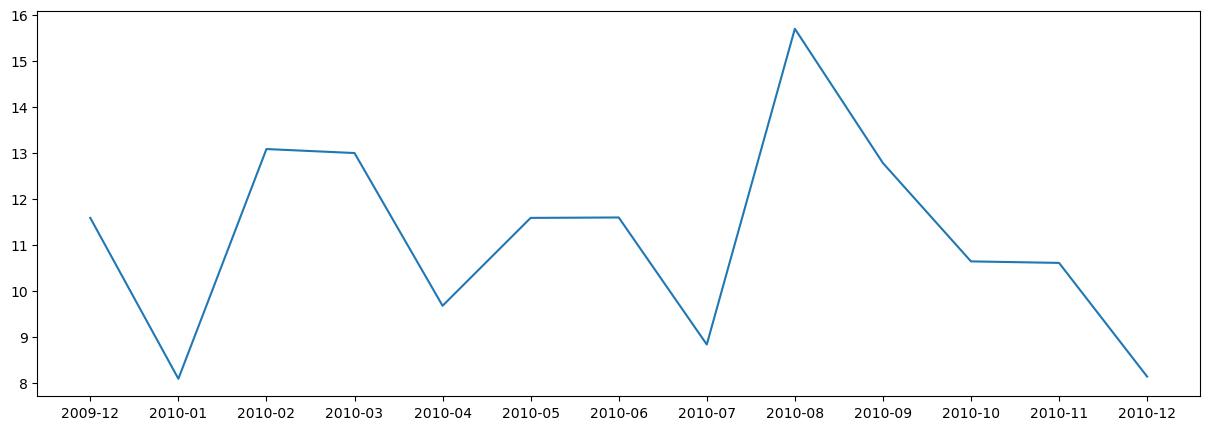

In [11]:
# plot price by date on x axis for stockcode 20979
plt.figure(figsize=(15,5))
plt.plot(dane[dane['StockCodeHash'] == 20979].groupby('YearMonth')['Quantity'].mean())




<Figure size 1000x600 with 0 Axes>

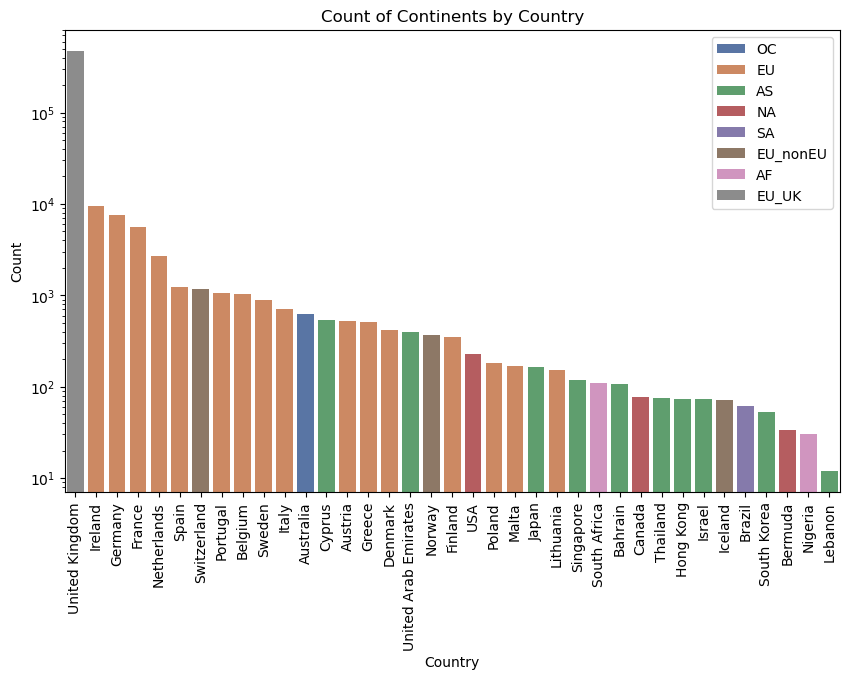

In [12]:
warnings.filterwarnings("ignore")
continent_counts = dane.groupby('Country')['Continent'].value_counts().reset_index(name='Count')
sorted_countries = continent_counts.groupby('Country').sum().sort_values(by='Count', ascending=False).index

plt.figure(figsize=(10, 6))

# Create a bar plot
plt.figure(figsize=(10, 6))

sns.barplot(x='Country', y='Count', hue='Continent', data=continent_counts,
            palette='deep', dodge=False, order=sorted_countries)

# Set labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Continents by Country')
plt.yscale("log")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()
warnings.filterwarnings("default")


In [13]:
def add_moving_mean_columns(df):

    df_price = df.groupby(['Year', 'Month', 'StockCodeHash','is_logged']).agg({'Price': 'mean'})
    df_price = df_price.reset_index()
    df_price = df_price.pivot_table(index=['Year', 'Month', 'StockCodeHash'], columns='is_logged', values='Price')

    # Rename the columns
    df_price = df_price.rename(columns={0: 'price_unlogged', 1: 'price_logged'})

    # Reset the index to convert the result back to a DataFrame
    df_price = df_price.reset_index()
    df_price["price_logged"].fillna(df_price["price_unlogged"]/2,inplace=True)
    df_price["price_unlogged"].fillna(df_price["price_logged"]*2,inplace=True)


    df_grouped = df.groupby(['Year', 'Month', 'StockCodeHash', 'Continent']).agg({'Quantity': 'sum'})
    df_grouped = df_grouped.reset_index()
    
    quantities_total = df_grouped.groupby(['Year', 'Month', 'StockCodeHash']).agg({'Quantity': 'sum'}).reset_index().rename(columns={'Quantity': 'quantity_month_worldwide'})
    quantities_total["shifted"] = quantities_total.groupby(['StockCodeHash'])['quantity_month_worldwide'].shift(1)
    quantities_total["shifted"].fillna(0,inplace=True)
    
    quantities_total["mean_worldwide"] = quantities_total.groupby("StockCodeHash")["shifted"].rolling(window=3).mean().reset_index(level=0, drop=True)
    quantities_total["mean_worldwide"].fillna(quantities_total["shifted"],inplace=True)
    df_grouped = df_grouped.merge(quantities_total, on=['Year', 'Month', 'StockCodeHash'], how='left').rename(columns={'Quantity': 'quantity_month_continent'})
    df_grouped = df_grouped.merge(df_price, on=['Year', 'Month', 'StockCodeHash'], how='left')
    return df_grouped


In [14]:
df = dane
df = add_moving_mean_columns(df)

In [15]:
df.drop(columns=["shifted","quantity_month_continent", "Continent"],inplace=True)

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df[(df['StockCodeHash'] == 20979)]

,Year,Month,StockCodeHash,quantity_month_worldwide,mean_worldwide,price_unlogged,price_logged
1045,2009,12,20979,707,0.000000,2.570000,1.240256
4970,2010,1,20979,170,707.000000,2.523333,1.250000
8562,2010,2,20979,301,292.333333,2.195000,1.237333
12335,2010,3,20979,390,392.666667,2.510000,1.241364
16250,2010,4,20979,213,287.000000,2.510000,1.238125
19904,2010,5,20979,255,301.333333,2.510000,1.250000
23731,2010,6,20979,232,286.000000,2.510000,1.250000
27582,2010,7,20979,221,233.333333,2.510000,1.250000
31328,2010,8,20979,471,236.000000,2.300000,1.242083
35067,2010,9,20979,294,308.000000,2.510000,1.250000


In [18]:
similar = pd.read_csv("df_most_similar_indexes.csv",index_col=0).drop(columns=["word2vec_vector","Invoice",	"Quantity",	"InvoiceDate",	"Price", "Customer ID",	"Country","Description","clean_text","Preprocessed Description"])

In [19]:
similar

,StockCodeHash,sim_ind_1,sim_ind_2,sim_ind_3,sim_ind_4,sim_ind_5,sim_cos_1,sim_cos_2,sim_cos_3,sim_cos_4,sim_cos_5
0,10002,3947,2690,1114,1115,2700,0.643465,0.623083,0.616785,0.611649,0.609330
1,10080,370,4390,1923,4456,4457,0.760418,0.705673,0.704472,0.702488,0.702488
2,10109,6,7,8,2665,4843,0.764022,0.764022,0.764022,0.746909,0.746019
3,10120,3458,33,4118,4129,1253,0.734656,0.731549,0.703451,0.703451,0.661971
4,10120,3699,1265,284,1858,4717,0.654593,0.550869,0.503163,0.501368,0.493487
...,...,...,...,...,...,...,...,...,...,...,...
5065,-2360902159825774783,5068,5067,5066,5064,5063,1.000000,1.000000,1.000000,1.000000,1.000000
5066,8725189771270228549,5068,5067,5065,5064,5063,1.000000,1.000000,1.000000,1.000000,1.000000
5067,-7530139991614082478,5068,5066,5065,5064,5063,1.000000,1.000000,1.000000,1.000000,1.000000
5068,5829484553763587174,5067,5066,5065,5064,5063,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df_ = df.merge(similar, on=['StockCodeHash'])

In [21]:
df_

,Year,Month,StockCodeHash,quantity_month_worldwide,mean_worldwide,price_unlogged,price_logged,sim_ind_1,sim_ind_2,sim_ind_3,sim_ind_4,sim_ind_5,sim_cos_1,sim_cos_2,sim_cos_3,sim_cos_4,sim_cos_5
0,2009,12,10002,216,0.000000,1.700000,0.850000,3947,2690,1114,1115,2700,0.643465,0.623083,0.616785,0.611649,0.609330
1,2010,1,10002,291,216.000000,1.660000,0.850000,3947,2690,1114,1115,2700,0.643465,0.623083,0.616785,0.611649,0.609330
2,2010,2,10002,257,169.000000,1.660000,0.850000,3947,2690,1114,1115,2700,0.643465,0.623083,0.616785,0.611649,0.609330
3,2010,3,10002,642,254.666667,1.660000,0.819412,3947,2690,1114,1115,2700,0.643465,0.623083,0.616785,0.611649,0.609330
4,2010,4,10002,1132,396.666667,1.660000,0.819048,3947,2690,1114,1115,2700,0.643465,0.623083,0.616785,0.611649,0.609330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30628,2010,12,22933,12,0.000000,5.900000,2.950000,2485,2489,2492,2487,1637,0.890735,0.884500,0.835747,0.833206,0.822518
30629,2010,12,22935,81,0.000000,6.166667,3.083333,2485,2490,2488,2492,2487,0.906995,0.903414,0.884500,0.855869,0.850154
30630,2010,12,22936,9,0.000000,6.500000,3.250000,2489,2486,2492,3863,2485,0.903414,0.896001,0.809119,0.805055,0.790781
30631,2010,12,22937,50,0.000000,5.100000,2.550000,2487,2492,2485,3674,3675,0.976273,0.941296,0.840903,0.837755,0.837755


In [22]:
warnings.filterwarnings("ignore")
df_.loc[:,"sim_ind_1"] = df_[['sim_ind_1']].apply(lambda x: df_.loc[x,"mean_worldwide"]).values * df_[['sim_cos_1']].values
df_.loc[:,"sim_ind_2"] =df_[['sim_ind_2']].apply(lambda x: df_.loc[x,"mean_worldwide"]).values * df_[['sim_cos_2']].values
df_.loc[:,"sim_ind_3"] =df_[['sim_ind_3']].apply(lambda x: df_.loc[x,"mean_worldwide"]).values * df_[['sim_cos_3']].values
df_.loc[:,"sim_ind_4"] =df_[['sim_ind_4']].apply(lambda x: df_.loc[x,"mean_worldwide"]).values * df_[['sim_cos_4']].values
df_.loc[:,"sim_ind_5"] =df_[['sim_ind_5']].apply(lambda x: df_.loc[x,"mean_worldwide"]).values * df_[['sim_cos_5']].values
warnings.filterwarnings("default")

In [23]:
df_

,Year,Month,StockCodeHash,quantity_month_worldwide,mean_worldwide,price_unlogged,price_logged,sim_ind_1,sim_ind_2,sim_ind_3,sim_ind_4,sim_ind_5,sim_cos_1,sim_cos_2,sim_cos_3,sim_cos_4,sim_cos_5
0,2009,12,10002,216,0.000000,1.700000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027,0.643465,0.623083,0.616785,0.611649,0.609330
1,2010,1,10002,291,216.000000,1.660000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027,0.643465,0.623083,0.616785,0.611649,0.609330
2,2010,2,10002,257,169.000000,1.660000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027,0.643465,0.623083,0.616785,0.611649,0.609330
3,2010,3,10002,642,254.666667,1.660000,0.819412,21.234354,55.869754,0.000000,0.000000,59.105027,0.643465,0.623083,0.616785,0.611649,0.609330
4,2010,4,10002,1132,396.666667,1.660000,0.819048,21.234354,55.869754,0.000000,0.000000,59.105027,0.643465,0.623083,0.616785,0.611649,0.609330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30628,2010,12,22933,12,0.000000,5.900000,2.950000,12.173381,10.908830,75.495856,0.000000,6.031800,0.890735,0.884500,0.835747,0.833206,0.822518
30629,2010,12,22935,81,0.000000,6.166667,3.083333,12.395602,49.085482,8.844997,77.313483,0.000000,0.906995,0.903414,0.884500,0.855869,0.850154
30630,2010,12,22936,9,0.000000,6.500000,3.250000,11.142103,4.778674,73.090458,9.660660,10.807337,0.903414,0.896001,0.809119,0.805055,0.790781
30631,2010,12,22937,50,0.000000,5.100000,2.550000,0.000000,85.030441,11.492337,97.458855,104.440149,0.976273,0.941296,0.840903,0.837755,0.837755


In [24]:
df_.drop(columns=["sim_cos_1","sim_cos_2","sim_cos_3","sim_cos_4","sim_cos_5"],inplace=True)

In [25]:
df_

,Year,Month,StockCodeHash,quantity_month_worldwide,mean_worldwide,price_unlogged,price_logged,sim_ind_1,sim_ind_2,sim_ind_3,sim_ind_4,sim_ind_5
0,2009,12,10002,216,0.000000,1.700000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027
1,2010,1,10002,291,216.000000,1.660000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027
2,2010,2,10002,257,169.000000,1.660000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027
3,2010,3,10002,642,254.666667,1.660000,0.819412,21.234354,55.869754,0.000000,0.000000,59.105027
4,2010,4,10002,1132,396.666667,1.660000,0.819048,21.234354,55.869754,0.000000,0.000000,59.105027
...,...,...,...,...,...,...,...,...,...,...,...,...
30628,2010,12,22933,12,0.000000,5.900000,2.950000,12.173381,10.908830,75.495856,0.000000,6.031800
30629,2010,12,22935,81,0.000000,6.166667,3.083333,12.395602,49.085482,8.844997,77.313483,0.000000
30630,2010,12,22936,9,0.000000,6.500000,3.250000,11.142103,4.778674,73.090458,9.660660,10.807337
30631,2010,12,22937,50,0.000000,5.100000,2.550000,0.000000,85.030441,11.492337,97.458855,104.440149


In [26]:
target = df_[["quantity_month_worldwide"]]
df_.drop(columns=["quantity_month_worldwide"],inplace=True)

In [27]:
df_

,Year,Month,StockCodeHash,mean_worldwide,price_unlogged,price_logged,sim_ind_1,sim_ind_2,sim_ind_3,sim_ind_4,sim_ind_5
0,2009,12,10002,0.000000,1.700000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027
1,2010,1,10002,216.000000,1.660000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027
2,2010,2,10002,169.000000,1.660000,0.850000,21.234354,55.869754,0.000000,0.000000,59.105027
3,2010,3,10002,254.666667,1.660000,0.819412,21.234354,55.869754,0.000000,0.000000,59.105027
4,2010,4,10002,396.666667,1.660000,0.819048,21.234354,55.869754,0.000000,0.000000,59.105027
...,...,...,...,...,...,...,...,...,...,...,...
30628,2010,12,22933,0.000000,5.900000,2.950000,12.173381,10.908830,75.495856,0.000000,6.031800
30629,2010,12,22935,0.000000,6.166667,3.083333,12.395602,49.085482,8.844997,77.313483,0.000000
30630,2010,12,22936,0.000000,6.500000,3.250000,11.142103,4.778674,73.090458,9.660660,10.807337
30631,2010,12,22937,0.000000,5.100000,2.550000,0.000000,85.030441,11.492337,97.458855,104.440149


In [28]:
import datetime

In [29]:
# make date column 
df_["date"] = df_[["Year","Month"]].apply(lambda x: datetime.datetime(x[0],x[1],1),axis=1)

# set date as index
df_.set_index("date",inplace=True)


# drop year and month
df_.drop(columns=["Year","Month"],inplace=True)


In [30]:
import pandas as pd

# Define the validation and test set sizes
val_size = 0.1
test_size = 0.1

# split data into train, validation and test sets
def split_data(data, val_size, test_size):
    """
    Splits data into train, validation and test sets.
    """
    # Calculate the size of the test set
    test_set_size = int(np.round(len(data)*test_size))
    # Calculate the size of the validation set
    val_set_size = int(np.round(len(data)*val_size))
    # Calculate the size of the training set
    train_set_size = len(data) - (val_set_size + test_set_size)
    
    # Split the data into training, validation and test sets
    train_set = data.iloc[:train_set_size]
    val_set = data.iloc[train_set_size:train_set_size+val_set_size]
    test_set = data.iloc[train_set_size+val_set_size:]

    target_train = target.iloc[:train_set_size]
    target_val = target.iloc[train_set_size:train_set_size+val_set_size]
    target_test = target.iloc[train_set_size+val_set_size:]
    
    return train_set, val_set, test_set, target_train, target_val, target_test

# Split the data into training, validation and test sets
train_set, val_set, test_set, target_train, target_val, target_test = split_data(df_, val_size, test_size)

In [31]:
train_set.reset_index(inplace=True, drop=True)
val_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)

In [32]:
target_train.reset_index(inplace=True, drop=True)
target_val.reset_index(inplace=True, drop=True)
target_test.reset_index(inplace=True, drop=True)

## XGBoost

[0]	validation_0-rmse:377.24678
[1]	validation_0-rmse:341.50587
[2]	validation_0-rmse:315.54252
[3]	validation_0-rmse:303.63868
[4]	validation_0-rmse:289.24937
[5]	validation_0-rmse:289.37838
[6]	validation_0-rmse:310.20511
[7]	validation_0-rmse:309.64769
[8]	validation_0-rmse:308.89388
[9]	validation_0-rmse:309.20320
[10]	validation_0-rmse:308.44535
[11]	validation_0-rmse:308.39063
[12]	validation_0-rmse:302.33985
[13]	validation_0-rmse:302.33800
[14]	validation_0-rmse:299.63535


c:\Users\adamm\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE: 440.587372


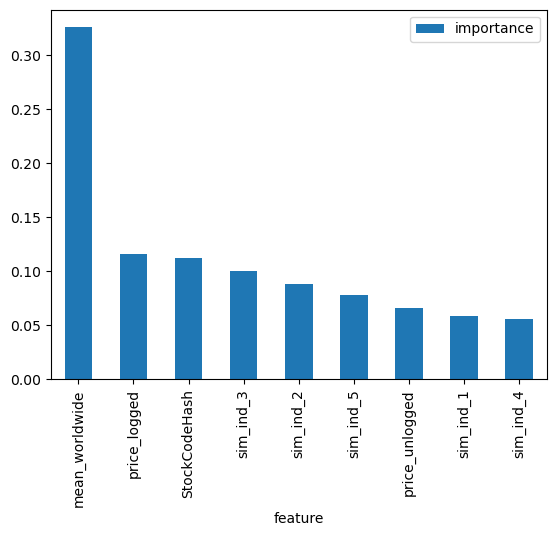

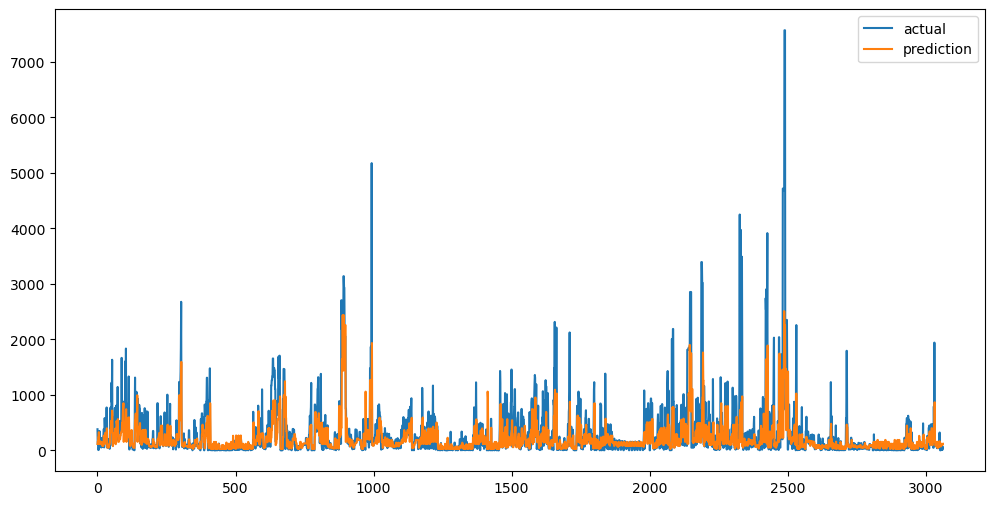

In [36]:
# do the same for xgboost

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Create the model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model
model.fit(train_set, target_train, eval_set=[(val_set, target_val)], early_stopping_rounds=10, verbose=True)

# Get predictions
preds = model.predict(test_set)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(target_test, preds))
print("RMSE: %f" % (rmse))

# Plot the feature importances
importances = pd.DataFrame({'feature':train_set.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

# Plot the predictions vs the actual values
plt.figure(figsize=(12,6))
plt.plot(target_test, label='actual')
plt.plot(preds, label='prediction')
plt.legend(loc='best')
plt.show()



## XGBoost

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[0]	validation_0-rmse:433.70543
[1]	validation_0-rmse:422.20590
[2]	validation_0-rmse:411.19825
[3]	validation_0-rmse:401.12643
[4]	validation_0-rmse:391.42733
[5]	validation_0-rmse:382.66074
[6]	validation_0-rmse:374.40684
[7]	validation_0-rmse:366.68783
[8]	validation_0-rmse:359.45786
[9]	validation_0-rmse:352.80778
[10]	validation_0-rmse:339.38349
[11]	validation_0-rmse:333.88381
[12]	validation_0-rmse:328.68345
[13]	validation_0-rmse:323.89870
[14]	validation_0-rmse:314.53306
[15]	validation_0-rmse:310.58285
[16]	validation_0-rmse:306.79554
[17]	validation_0-rmse:301.51178
[18]	validation_0-rmse:296.64552
[19]	validation_0-rmse:293.93213
[20]	validation_0-rmse:291.45521
[21]	validation_0-rmse:289.34211
[22]	validation_0-rmse:287.36519
[23]	validation_0-rmse:286.35662
[24]	validation_0-rmse:284.74627
[25]	validation_0-rmse:283.33463
[26]	validation_0-rmse:282.10812
[27]	validation_0-rmse:280.73970
[28]	validation_0-rmse:

c:\Users\adamm\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE: 454.277049


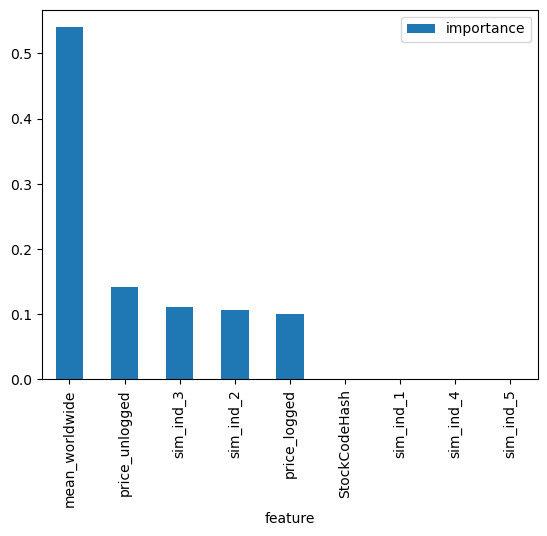

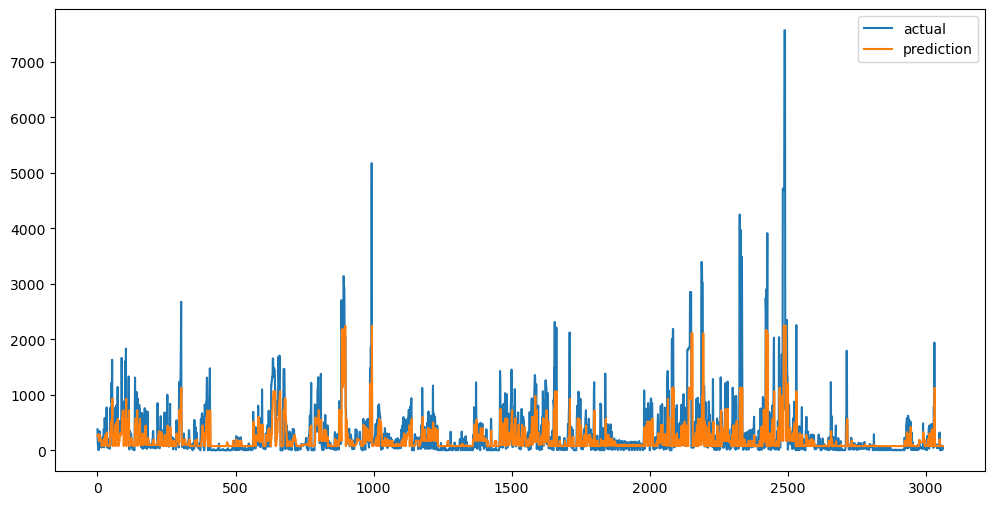

In [37]:

# grid search
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 500, 1000],
    'gamma': [0.5, 1, 5],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0, 0.5],
    }

# Create a based model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(train_set, target_train)
grid_search.best_params_

max_depth = grid_search.best_params_["max_depth"]
n_estimators = grid_search.best_params_["n_estimators"]
learning_rate = grid_search.best_params_["learning_rate"]
gamma = grid_search.best_params_["gamma"]
reg_alpha = grid_search.best_params_["reg_alpha"]
reg_lambda = grid_search.best_params_["reg_lambda"]


# Create the model
model = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, gamma = gamma, reg_alpha = reg_alpha, reg_lambda = reg_lambda, objective='reg:squarederror', random_state=42)

# Fit the model
model.fit(train_set, target_train, eval_set=[(val_set, target_val)], early_stopping_rounds=10, verbose=True)

# Get predictions
preds = model.predict(test_set)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(target_test, preds))
print("RMSE: %f" % (rmse))

# Plot the feature importances
importances = pd.DataFrame({'feature':train_set.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

# Plot the predictions vs the actual values
plt.figure(figsize=(12,6))
plt.plot(target_test, label='actual')
plt.plot(preds, label='prediction')
plt.legend(loc='best')
plt.show()




## LightGBM

In [39]:
# grid search
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Create the parameter grid based on the results of random search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 500, 1000],
    'num_leaves': [2, 4, 8],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 1, 1.5, 2],

    }

# Create a based model
model = LGBMRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid,

                            cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(train_set, target_train)
grid_search.best_params_

max_depth = grid_search.best_params_["max_depth"]
n_estimators = grid_search.best_params_["n_estimators"]
learning_rate = grid_search.best_params_["learning_rate"]
num_leaves = grid_search.best_params_["num_leaves"]
reg_alpha = grid_search.best_params_["reg_alpha"]
reg_lambda = grid_search.best_params_["reg_lambda"]

# Create the model
model = LGBMRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=42)

# Fit the model
model.fit(train_set, target_train, eval_set=[(val_set, target_val)], early_stopping_rounds=10, verbose=True)

# Get predictions
preds = model.predict(test_set)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(target_test, preds))
print("RMSE: %f" % (rmse))

# Plot the feature importances
importances = pd.DataFrame({'feature':train_set.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

# Plot the predictions vs the actual values
plt.figure(figsize=(12,6))
plt.plot(target_test, label='actual')
plt.plot(preds, label='prediction')
plt.legend(loc='best')
plt.show()

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
